In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
#import networkx as nx
import pandas as pd
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

In [2]:
df = pd.read_csv("data/villes.csv", sep=";", encoding="ISO-8859-1")
V = df.iloc[:, 0].values
names = df.iloc[:, 1].values
names = np.array([name.strip(' ') for name in names])
n = V.size
D = np.nan_to_num(df.iloc[:, 2:].values)
D = D+D.T
DV = D*V.reshape(-1, 1)

In [3]:
class AffectationUniteSoin:
    def __init__(self, K=3, alpha=0.1, D=D, V=V, DV=DV, random=[]):
        """

        :param N:
        :param K:
        :param DFile:
        """
        self.k = K
        self.V = V
        self.n = self.V.size
        self.D = D
        self.DV = DV
        
        if random != []:
            #self.P = np.argsort(V)[::-1][:k].astype(int)
#             self.P = np.zeros((self.n, 1))
#             idx = np.random.permutation(np.arange(self.k)).astype(dtype=int)[:self.k]
#             self.P[idx] = 1
#             self.P = np.array([5, 8, 10, 13, 14])
            self.P = np.array(random)
            self.DV = DV[:, self.P]

        self.alpha = alpha
        self.gamma = (1+self.alpha)/self.k * self.V.sum()
        self.model = gp.Model("Unite de soin")

        print("Setting up variables ...")
        self.setupVariables()
        print("Setting up Constraints ...")
        self.setupConstraints()
        print("Setting up Objective ...")
        self.objective()


    def solve(self):
        """

        :return:
        """
        return self.model.optimize()

    def setupVariables(self):
        """

        :return:
        """
        self.X = self.model.addMVar(shape=(self.n, self.k), vtype=GRB.BINARY, name="X")
        return


    def setupConstraints(self):
        """

        :return:
        """
        self.model.addConstrs((sum(self.X[i, j] for j in range(self.X.shape[1])) == 1 for i in range(self.n)), name=f"contraine_ville");
        self.model.addConstrs((sum(self.V[i]*self.X[i, j] for i in range(self.n)) <= self.gamma for j in range(self.k)), name=f"equilibrage");

    def objective(self):
        """

        :return:
        """
#         obj = sum(self.X[:, j] @ self.DV[:, j] for j in range(self.k))
#         self.model.setObjective(obj, GRB.MINIMIZE)
        obj = sum(self.X[i, j]*self.DV[i, j] for i, j in product(range(self.n), range(self.k)))/self.V.sum()
        self.model.setObjective(obj, GRB.MINIMIZE)

    def att(self):
        if self.model.status == GRB.INFEASIBLE:
            return None
        return self.X.X.astype(np.uint), self.P.astype(np.uint)
    
    def evaluateObjective(self):
        if self.model.status == GRB.INFEASIBLE:
            return np.inf 
        print("WHYYYYY ???")
        Xm, Pm = self.att()
        Zm = (Xm*self.D).max()
        idx = np.where(Pm == 1)[0]
        print("Objectif: ", self.model.objval, "; max distance: ", Zm)
        for i in idx:
            print(f"Secteur {names[i]}: {names[Xm[:, i]==1]}, population: {Xm[:, i]@V}")

        return self.model.objval
        



        

In [4]:
class AffectationUniteSoinLocation(AffectationUniteSoin):
    def __init__(self, K=3, alpha=0.1, D=D, V=V, DV=DV):
        """

        :param N:
        :param K:
        :param obj: either mean_dist, max_dist to setup the optimization strategy
        """
        super().__init__(K=K, alpha=alpha, D=D, V=V, DV=DV, random=[])


    def setupVariables(self):
        """
        """
        self.X = self.model.addMVar((n, n), lb=0, vtype=GRB.BINARY, name="X")
        self.P = self.model.addMVar((n, 1), lb=0, vtype=GRB.BINARY, name="P")
        
    def setupConstraints(self):
        """
        """
        self.model.addConstrs((self.X[i].sum() == 1 for i in range(self.n)), name=f"contraine_ville");
        self.model.addConstr(self.P.sum() == self.k , name=f"contraine_unite");
        self.model.addConstrs((self.V@self.X[:, j] <= self.gamma for j in range(self.n)), name=f"equilibrage");
        #self.model.addConstrs((self.X[i][i] == self.P[i] for i in range(self.n)), name="fix")
        
        self.model.addConstrs((self.X[i][j] <= self.P[j] 
                              for i,j in product(range(self.n), range(self.n))),
                                 name=f"contraine_ville_dans_sec");

    def objective(self):
        """
        """
        obj = sum(self.X[:, j]@self.DV[:, j] for j in range(self.n))/self.V.sum()
        self.model.setObjective(obj, GRB.MINIMIZE)

    def att(self):
        if self.model.status == GRB.INFEASIBLE:
            return None
        return self.X.X.astype(np.uint), self.P.X.astype(np.uint)
        

In [5]:
class AffectationUniteSoinMaxDist(AffectationUniteSoinLocation):
    def __init__(self, K=3, alpha=0.1, D=D, V=V, DV=DV):
        """
        :param N:
        :param K:
        """
        super().__init__(K=K, alpha=alpha, D=D, V=V, DV=DV)
    def setupVariables(self):
        """
        """
        super().setupVariables()
        self.Z = self.model.addMVar(1, lb=0, vtype=GRB.CONTINUOUS, name="Z")
        
        
    def setupConstraints(self):
        """
        """
        
        self.model.addConstrs((self.Z >= self.D[i][j]*self.X[i][j]
                      for i,j in product(range(self.n), range(self.n))),
                        name=f"maxDistance");
        super().setupConstraints()
    def objective(self):
        """
        """
        obj = self.Z
        self.model.setObjective(obj, GRB.MINIMIZE)
    

In [6]:
model1 = AffectationUniteSoinLocation(K=3, alpha=0.2)
model1.solve()

model2 = AffectationUniteSoinMaxDist(K=3, alpha=0.2)
model2.solve()

Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...


In [7]:
model1.evaluateObjective()

WHYYYYY ???
Objectif:  228.0857769673166 ; max distance:  501.0
Secteur Nantes: ['Nantes' 'Bordeaux' 'Rennes' 'Le Havre' 'Angers'], population: 1103704
Secteur Montpellier: ['Toulouse' 'Nice' 'Montpellier' 'Toulon'], population: 1276644
Secteur Dijon: ['Strasbourg' 'Lille' 'Reims' 'Saint-Étienne' 'Grenoble' 'Dijon'], population: 1184152


228.0857769673166

In [8]:
model2.evaluateObjective()

WHYYYYY ???
Objectif:  458.0 ; max distance:  458.0
Secteur Montpellier: ['Nice' 'Montpellier' 'Saint-Étienne' 'Toulon' 'Grenoble'], population: 1128110
Secteur Bordeaux: ['Toulouse' 'Nantes' 'Bordeaux' 'Rennes'], population: 1260150
Secteur Reims: ['Strasbourg' 'Lille' 'Reims' 'Le Havre' 'Dijon' 'Angers'], population: 1176240


458.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...

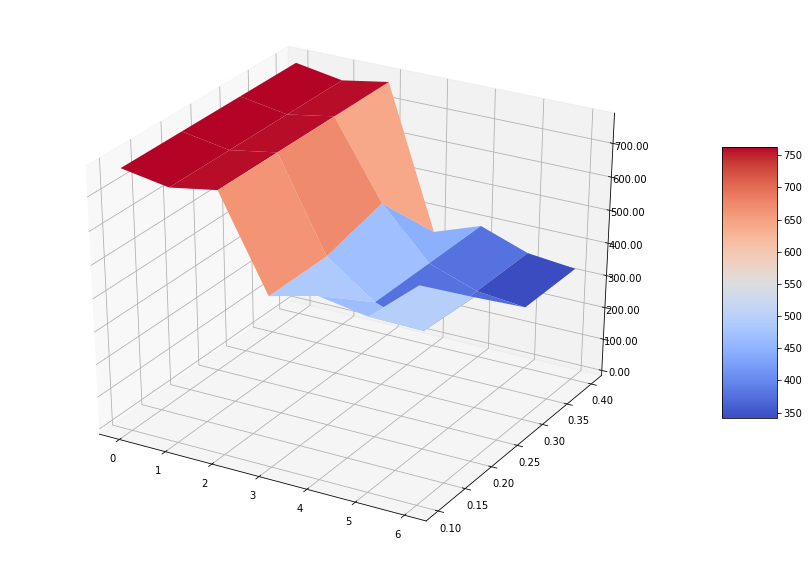

In [35]:
X = np.arange(7)
Y = np.arange(0.1, 0.4, 0.1)

XX, YY = np.meshgrid(X, Y)

Z = np.zeros((X.shape[0], Y.shape[0]))

for i, j in product(range(len(X)), range(len(Y))):
    model = AffectationUniteSoinLocation(X[i], Y[j])
    model.solve()
    att = model.att()
    if (att == None):
        maxz =np.inf
    else:    
        maxz = (att[0]*model.D).max()
    Z[i, j] = maxz #model.evaluateObjective()

Z[Z == np.inf] = Z[1:, :].max()

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(XX, YY, Z.T, cmap=cm.coolwarm)


ax.set_zlim(0, Z.max())
# ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

fig.savefig("AvgParams.png")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
WHYYYYY ???
Objectif:  660.0 ; max distance:  660.0
Secteur Dijon: ['Toulouse' 'Nice' 'Nantes' 'Montpellier' 'Strasbourg' 'Bordeaux' 'Lille'
 'Rennes' 'Reims' 'Saint-Étienne' 'Toulon' 'Le Havre' 'Grenoble' 'Dijon'
 'Angers'], population: 3564500
Setting up variables ...
Setting up Constraints ...
Setting up Objective ...
WHYYYYY ???
Objectif:  660.0 ; max distance:  660.0
Secteur Dijon: ['Toulouse' 'Nice' 'Nantes' 'Montpellier' 'Strasbourg' 'Bordeaux' 'Lille'
 'Rennes' 'Reims' 'Saint-Étienne' 'Toulon' 'Le Havre' 'Grenoble' 'Dijon'
 'Angers'], population: 3564500
Setting up variables ...
Setting up Constraint

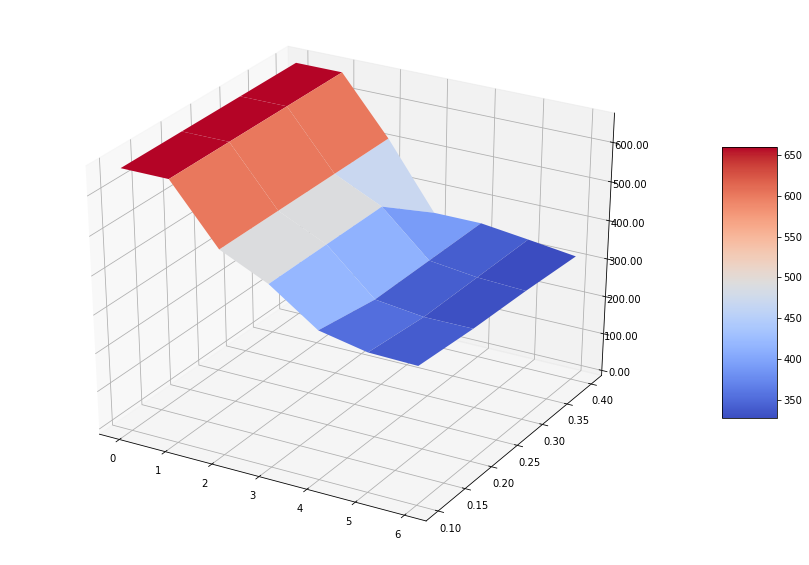

In [36]:
X = np.arange(7)
Y = np.arange(0.1, 0.4, 0.1)

XX, YY = np.meshgrid(X, Y)

Z = np.zeros((X.shape[0], Y.shape[0]))

for i, j in product(range(len(X)), range(len(Y))):
    model = AffectationUniteSoinMaxDist(X[i], Y[j])
    model.solve()
    Z[i, j] = model.evaluateObjective()

Z[Z == np.inf] = Z[1:, :].max()

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(XX, YY, Z.T, cmap=cm.coolwarm)


ax.set_zlim(0, Z.max())
# ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig("MaxParams.png")
plt.show()

In [10]:
import geopy

from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="agent")
location = geolocator.geocode(names[0])
print(location.address)
print((location.latitude, location.longitude))

Toulouse, Haute-Garonne, Occitanie, France métropolitaine, France
(43.6044622, 1.4442469)


In [11]:
maps = [(geolocator.geocode(name).latitude, geolocator.geocode(name).longitude) for name in names]
maps

[(43.6044622, 1.4442469),
 (43.7009358, 7.2683912),
 (47.2186371, -1.5541362),
 (43.6112422, 3.8767337),
 (48.584614, 7.7507127),
 (44.841225, -0.5800364),
 (50.6365654, 3.0635282),
 (48.1113387, -1.6800198),
 (49.2577886, 4.031926),
 (45.4401467, 4.3873058),
 (43.1257311, 5.9304919),
 (49.4938975, 0.1079732),
 (45.1875602, 5.7357819),
 (47.3215806, 5.0414701),
 (47.4739884, -0.5515588)]

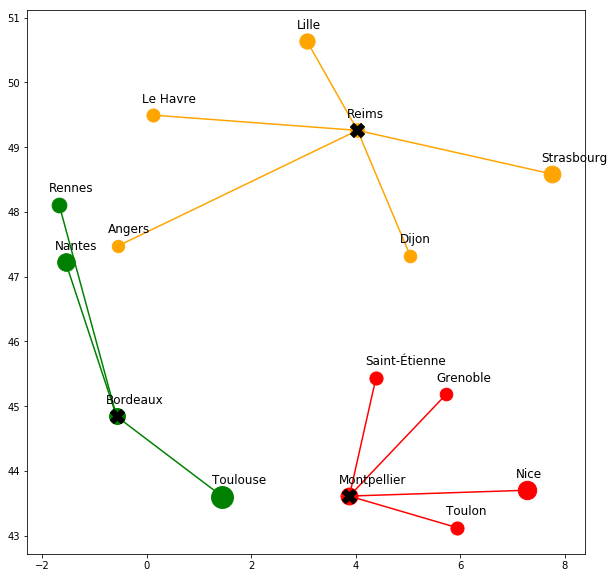

In [12]:
y, x = zip(*maps)

X = model2.X.X.astype(int)
Y = model2.P.X.astype(int)
# colors = np.array([np.random.rand(3,) for i in range(Y.sum())])

colors = ["red", "green", "orange", "purple", "brown"]
def drawSolution(X, Y):
    clusters = np.where(Y  == 1)[0]

    plt.figure(figsize=(10,10))

    for j in range(Y.sum()):
        for i in np.where(X[:, clusters[j]] == 1)[0]:
            plt.scatter(x[i], y[i], V[i]/1000, color=colors[j])
            plt.text(x[i]-0.2, y[i]+0.2, names[i], fontsize=12)
            plt.plot([x[clusters[j]], x[i]], [y[clusters[j]], y[i]], color=colors[j], zorder=1)

        plt.scatter(x[clusters[j]], y[clusters[j]], 200, marker="X", color="black", zorder=2)

drawSolution(X, Y)

In [13]:
def randomVectorP(n=5):
    """
    """
    maxVal = 500
    P = []
    for i in range(n):
        tmp = np.random.randint(0, maxVal)
        maxVal -= tmp
        P.append(tmp)
    return np.random.permutation(P)

In [14]:
randomVectorP()

array([388,  60,   3,  12,  26])

In [15]:
model = AffectationUniteSoinMaxDist(5, 0.2)
model.solve()

Setting up variables ...
Setting up Constraints ...
Setting up Objective ...


In [16]:
X, Y = model.att()
X,Y

(array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint32),
 array([[0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
   

In [17]:
model.evaluateObjective()

WHYYYYY ???
Objectif:  332.0 ; max distance:  332.0
Secteur Nantes: ['Nantes' 'Rennes' 'Angers'], population: 679121
Secteur Montpellier: ['Nice' 'Montpellier' 'Toulon'], population: 797091
Secteur Bordeaux: ['Toulouse' 'Bordeaux'], population: 733989
Secteur Lille: ['Lille' 'Reims' 'Le Havre'], population: 585394
Secteur Dijon: ['Strasbourg' 'Saint-Étienne' 'Grenoble' 'Dijon'], population: 768905


332.0

In [18]:
model.gamma

855480.0

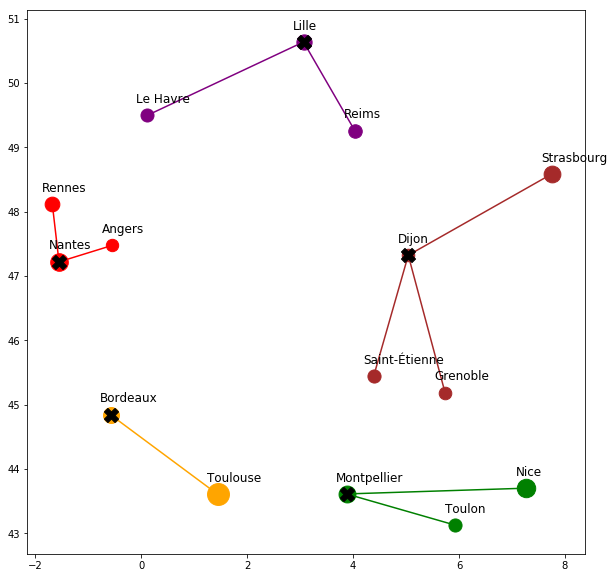

In [19]:
drawSolution(X, Y)

Setting up variables ...
Setting up Constraints ...
Setting up Objective ...


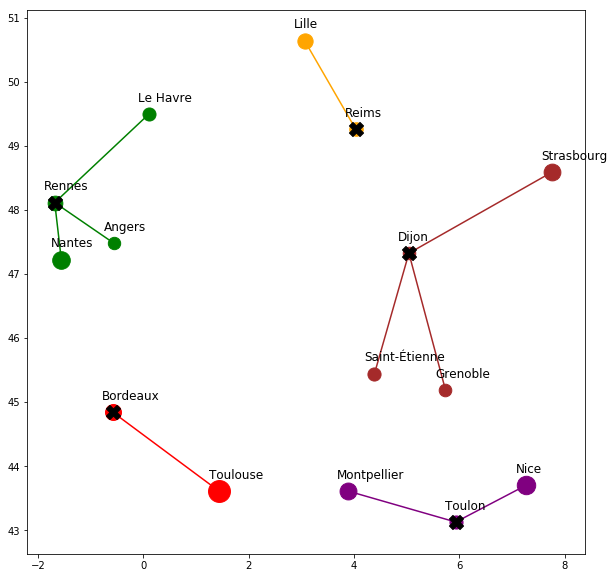

In [20]:
model3 = AffectationUniteSoin(5, 0.2, random=[5, 7, 8, 10, 13])

model3.solve()

X1, Y1 = model3.att()
X1, Y1

def drawSolution2(X, Y):
    plt.figure(figsize=(10,10))

    for j in range(len(Y)):
        for i in np.where(X[:, j] == 1)[0]:
            plt.scatter(x[i], y[i], V[i]/1000, color=colors[j])
            plt.text(x[i]-0.2, y[i]+0.2, names[i], fontsize=12)
            plt.plot([x[Y[j]], x[i]], [y[Y[j]], y[i]], color=colors[j], zorder=1)

        plt.scatter(x[Y[j]], y[Y[j]], 200, marker="X", color="black", zorder=2)
        
drawSolution2(X1, Y1)

In [35]:
# idx = np.random.permutation(np.arange(n))[:5]
# idx2 = np.where(y == 1)[0]
# P = randomVectorP()

# cost = np.zeros((12, 12))
# cost[1:6, 6:-1] = D[idx][:, idx2]

# capacity = np.zeros((12, 12))
# capacity[0, 1:6] = P
# capacity[6:-1, -1] = 100
# capacity[1:6, 6:-1] = np.inf

# plt.imshow(cost)
# plt.show()
# plt.imshow(capacity)

In [36]:
idx = [5, 8, 10, 13, 14]
idx2 = np.where(Y == 1)[0]
P = randomVectorP()
P = np.array([150,150,25,150,25])
cost = D[idx2][:, idx2]

flow = gp.Model("maxflowmincost")
F = flow.addMVar((5, 5), vtype=GRB.INTEGER, name="F")
S = flow.addMVar((5, 1), vtype=GRB.INTEGER, name="S")
T = flow.addMVar((5, 1), vtype=GRB.INTEGER, name="T")

d = P.sum()
print(f"D = {d}")
# contraintes
flow.addConstrs((S[i] <= P[i] for i in range(5)), name="capacityS")
flow.addConstrs((T[i] <= 100 for i in range(5)), name="capacityT")
flow.addConstrs((F[i].sum() == S[i] for i in range(5)), name="conservationS")
flow.addConstrs((F[:, i].sum() == T[i] for i in range(5)), name="conservationT")
flow.addConstr(S.sum() == d, name="requiredFlowS")
flow.addConstr(T.sum() == d, name="requiredFlowT")
# objectif
obj = sum(F[i, j]*cost[i, j] for i, j in product(range(5), range(5)))
flow.setObjective(obj, GRB.MINIMIZE)
# solve

D = 500


In [37]:
flow.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 22 rows, 35 columns and 80 nonzeros
Model fingerprint: 0x8220c0bd
Variable types: 0 continuous, 35 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 5e+02]
Found heuristic solution: objective 181925.00000
Presolve removed 12 rows and 10 columns
Presolve time: 0.00s
Presolved: 10 rows, 25 columns, 50 nonzeros
Variable types: 0 continuous, 25 integer (0 binary)

Root relaxation: objective 8.157500e+04, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    81575.000000 81575.0000  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.02 seconds
Thread cou

In [38]:
f = F.X.astype(int)

In [39]:
(cost*f).sum()

81575.0

In [157]:
for i in range(5):
    for j in range(5):
        if f[i, j] != 0:
            print(f"transferer {f[i, j]} malades du secteur {idx[i]}, au secteur {idx[j]}, coup transport : {cost[i, j]}")

transferer 100 malades du secteur 5, au secteur 5, coup transport : 0.0
transferer 25 malades du secteur 5, au secteur 10, coup transport : 803.0
transferer 25 malades du secteur 5, au secteur 14, coup transport : 660.0
transferer 100 malades du secteur 8, au secteur 8, coup transport : 0.0
transferer 50 malades du secteur 8, au secteur 10, coup transport : 347.0
transferer 25 malades du secteur 10, au secteur 10, coup transport : 0.0
transferer 100 malades du secteur 13, au secteur 13, coup transport : 0.0
transferer 50 malades du secteur 13, au secteur 14, coup transport : 501.0
transferer 25 malades du secteur 14, au secteur 14, coup transport : 0.0


In [52]:
T.X.astype(int)

array([[100],
       [100],
       [100],
       [100],
       [100]])

In [53]:
F.X.astype(int)

array([[100,  25,   0,  25,   0],
       [  0,  50, 100,   0,   0],
       [  0,   0,   0,  25,   0],
       [  0,   0,   0,  50, 100],
       [  0,  25,   0,   0,   0]])